In [26]:
import pandas as pd
import folium as fo
import numpy as np
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)

In [27]:
inspection_dataset = pd.read_parquet('resources/extended_dataset.parquet').dropna(subset=['Ward']).astype({'Ward': 'int32'})
crime_dataset = pd.read_csv('resources/chicago_crime.csv').dropna(subset=['Ward']).astype({'Ward': 'int32', 'Date': 'str'})

with open('resources/geojsons/chicago-wards.geojson') as f0:
    chicago_wards = json.load(f0)

C:\Users\Nicolas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
inspection_dataset['Year'] = inspection_dataset['Inspection Date'].map(lambda x: x.year)
inspection_dataset['Month'] = inspection_dataset['Inspection Date'].map(lambda x: x.month)
inspection_dataset = inspection_dataset[(inspection_dataset.Year > 2009) & (inspection_dataset.Year < 2019)]

In [29]:
crime_dataset['Year'] = crime_dataset.Date.map(lambda x: x.split(' ')[0].split('/')[2]).astype('int64')
crime_dataset['Month'] = crime_dataset.Date.map(lambda x: x.split(' ')[0].split('/')[0]).astype('int64')
crime_dataset = crime_dataset[(crime_dataset.Year > 2009) & (crime_dataset.Year < 2019)]

In [30]:
crime_dataset['Crimes'] = 1
crime_dataset['Arrests'] = crime_dataset['Arrest'] == True

agg_crime = crime_dataset.groupby(by=['Ward','Year']).agg(sum)[['Crimes', 'Arrests']]
agg_crime['Rate'] = (agg_crime.Arrests / agg_crime.Crimes)
agg_crime.head(5)

Crimes  Arrests      Rate
Ward Year                           
1    2010    7269   1404.0  0.193149
     2011    6661   1229.0  0.184507
     2012    6261   1156.0  0.184635
     2013    5361    840.0  0.156687
     2014    4653    719.0  0.154524

In [31]:
inspection_dataset['Inspections'] = 1
inspection_dataset['fails'] = inspection_dataset['Results'] == 'Fail'

col_to_drop = ['Inspection ID', 'License #', 'Latitude', 'Longitude', 'Zip']
col_rename = {'Re-inspection': 'reinspections', 'Inspections':'inspections', 'Nb Violations': 'violations', 'Nb Violations of high severity': 'high', 'Nb Violations of medium severity': 'medium', 'Nb Violations of low severity': 'low'}
col_order = ['inspections', 'fails', 'reinspections', 'violations', 'high', 'medium', 'low']

inspections_per_ward = inspection_dataset.groupby(by=['Ward','Year']).agg(sum).drop(col_to_drop, axis=1).rename(columns=col_rename)
inspections_per_ward['fail_rate'] = (inspections_per_ward.fails / inspections_per_ward.inspections)
inspections_per_ward.head(5)

reinspections  violations  high  medium   low  Month  inspections  \
Ward Year                                                                      
1    2010          122.0        1807    91     132  1584   3848          576   
     2011          100.0        1554    79     151  1324   3563          589   
     2012          166.0        2038   108     275  1655   4467          667   
     2013          160.0        2165   104     242  1819   4926          709   
     2014          125.0        2636   131     168  2337   5179          783   

           fails  fail_rate  
Ward Year                    
1    2010  133.0   0.230903  
     2011  132.0   0.224109  
     2012  169.0   0.253373  
     2013  161.0   0.227080  
     2014  122.0   0.155811

In [32]:
inspections_per_ward.join(agg_crime).corr()

,reinspections,violations,high,medium,low,Month,inspections,fails,fail_rate,Crimes,Arrests,Rate
reinspections,1.000000,0.951963,0.694835,0.966826,0.937446,0.910768,0.918702,0.972940,0.179383,0.334444,0.175896,-0.051364
violations,0.951963,1.000000,0.745727,0.940329,0.991429,0.949985,0.957681,0.922017,0.014861,0.290561,0.128088,-0.096820
high,0.694835,0.745727,1.000000,0.759175,0.656672,0.632815,0.668093,0.637694,0.060214,0.215811,0.034197,-0.191666
medium,0.966826,0.940329,0.759175,1.000000,0.908012,0.877721,0.889712,0.927055,0.133895,0.322335,0.156044,-0.095870
low,0.937446,0.991429,0.656672,0.908012,1.000000,0.956633,0.958651,0.915120,-0.008541,0.282106,0.132983,-0.075082
Month,0.910768,0.949985,0.632815,0.877721,0.956633,1.000000,0.993879,0.889873,-0.125123,0.327183,0.163312,-0.058369
inspections,0.918702,0.957681,0.668093,0.889712,0.958651,0.993879,1.000000,0.895031,-0.123602,0.331552,0.159075,-0.068862
fails,0.972940,0.922017,0.637694,0.927055,0.915120,0.889873,0.895031,1.000000,0.268451,0.374285,0.230820,0.010010
fail_rate,0.179383,0.014861,0.060214,0.133895,-0.008541,-0.125123,-0.123602,0.268451,1.000000,0.251507,0.258183,0.239567
Crimes,0.334444,0.290561,0.215811,0.322335,0.282106,0.327183,0.331552,0.374285,0.251507,1.000000,0.919960,0.639696


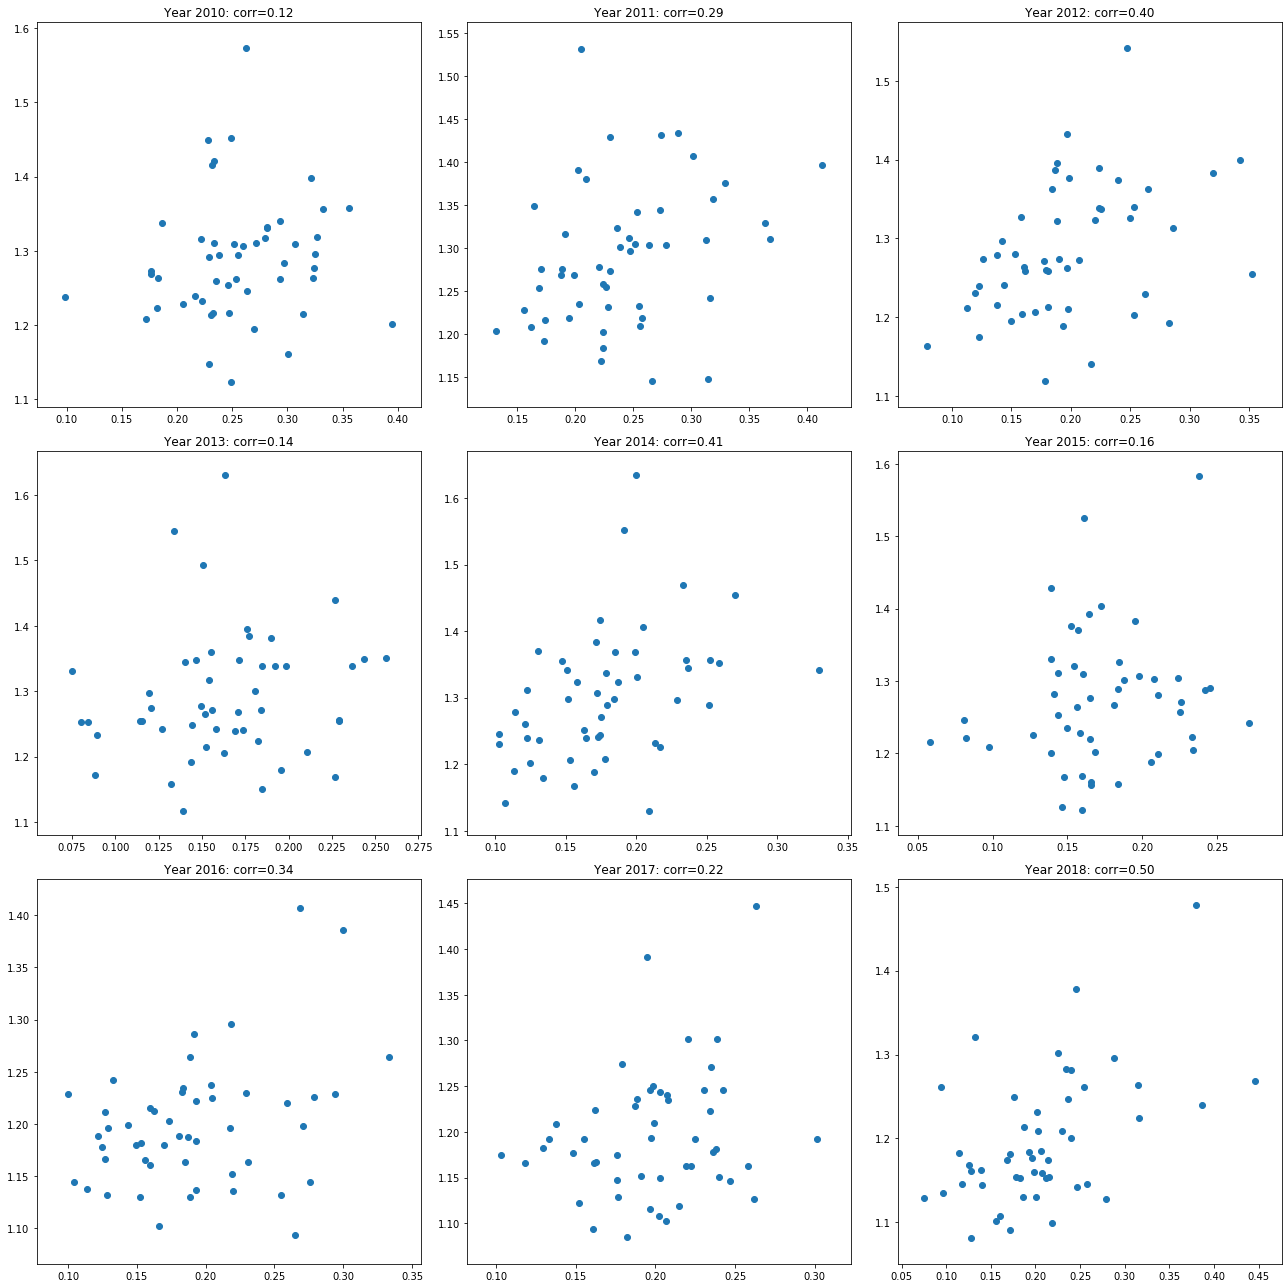

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(18,18))

for i, year in enumerate(range(2010, 2019)):
    ser1 = inspections_per_ward.reset_index()
    x = ser1[ser1.Year == year]
    x.index = x.Ward
    x = x['fail_rate']

    ser2 = agg_crime.reset_index()
    y = ser2[ser2.Year == year]
    y.index = y.Ward
    y = np.exp(y['Rate'])

    axs[int(i/3)][i%3].set_title('Year {0}: corr={1:.2f}'.format(year, np.corrcoef(x,y)[0,1]))
    axs[int(i/3)][i%3].scatter(x=x, y=y)
    
plt.tight_layout()
plt.show()

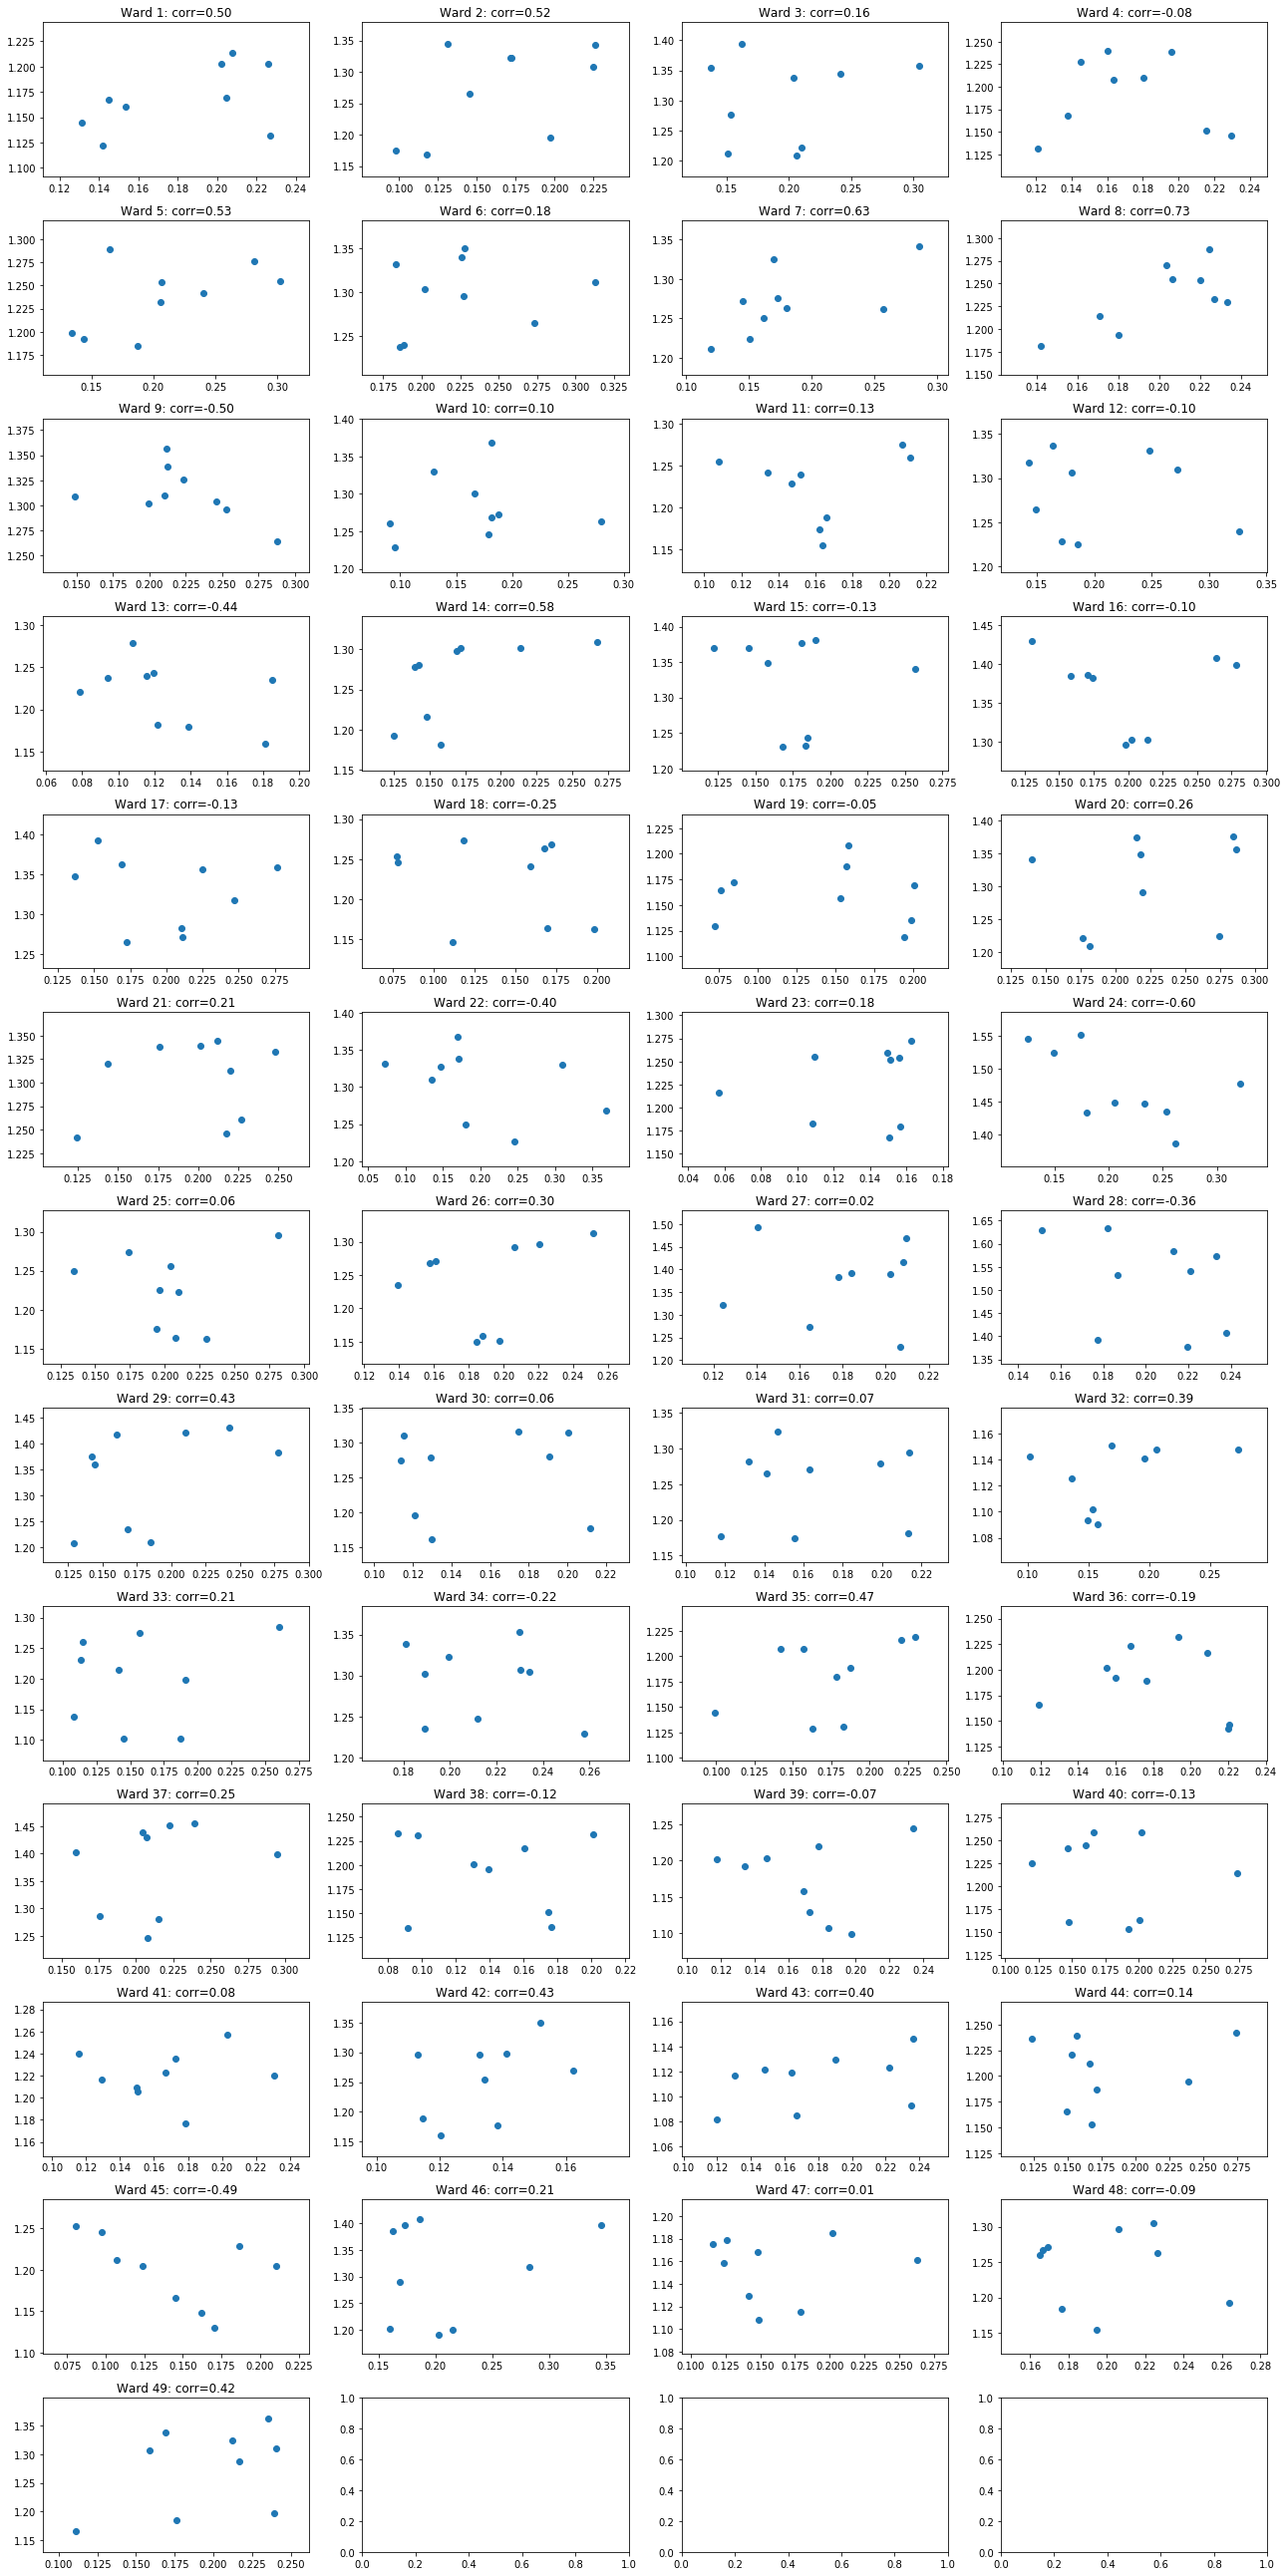

In [34]:
fig, axs = plt.subplots(13, 4, figsize=(18,36))
reseted_ins = inspections_per_ward.reset_index()
reseted_cri = agg_crime.reset_index()

for i, ward in enumerate(range(1, 50)):
    x = reseted_ins[reseted_ins.Ward == ward]
    x.index = x.Year
    x = np.log(x['fail_rate'] + 1)

    y = reseted_cri[reseted_cri.Ward == ward]
    y.index = y.Year
    y = np.exp(y['Rate'])

    axs[int(i/4)][i%4].set_title('Ward {0}: corr={1:.2f}'.format(ward, np.corrcoef(x,y)[0,1]))
    axs[int(i/4)][i%4].scatter(x=x, y=y)
    
plt.tight_layout()
plt.show()